## Testing NP implementation on 1D functions sampled from a Gaussian Process


This notebook provides a usage example with the full pyTorch lightning module infrastructure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from pl_modules import *
from pl_datasets import *

#### Generate and visualise data

In [2]:
 dm = NPDataModule(dataset_type='gpdata',
                      num_workers=4,
                      batch_size=16,
                      kernel='rbf',
                      num_samples=1000,
                      num_points=100,
                      lengthscale_range=(0.25, 0.5),
                      sigma_range=(1,1))

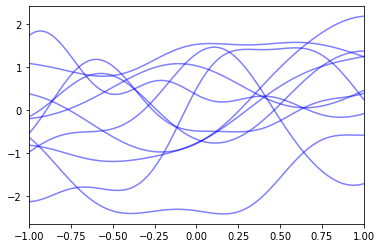

In [3]:
# Visualize data samples
for i in range(10):
    x, y = dm.train_loader.dataset[i] 
    plt.plot(x.squeeze(), y.squeeze(), c='b', alpha=0.5)
    plt.xlim(-1, 1)

#### Initialise module and visualise prior samples

In [4]:
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder
h_dim_enc = [50, 50] # Encoder hidden layers
h_dim_dec = [50, 50, 50] # Decoder hidden layers
training_type = 'VI' # training type to use, VI or MLE
num_context = 16
num_target = 32
model = PLNeuralProcess(x_dim=dm.x_dim,
                        y_dim=dm.y_dim,
                        lr=1e-3,
                        num_context=num_context,
                        num_target=num_target,
                        fix_n_context_and_target_points=False,
                        r_dim=r_dim,
                        z_dim=z_dim,
                        h_dim=h_dim,
                        h_dim_enc=h_dim_enc,
                        h_dim_dec=h_dim_dec,
                        n_repeat=1,
                        training_type=training_type)

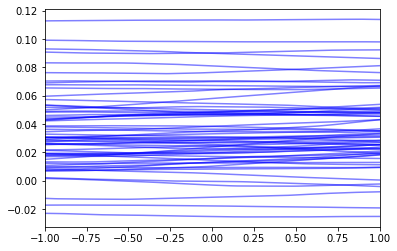

In [5]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-1, 1, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to the target distribution (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = model.model.decoder(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-1, 1)

#### Create and run trainer

In [10]:
trainer = pl.Trainer(gpus=0 if not torch.cuda.is_available() else 1,
                    max_epochs=100,
                    checkpoint_callback=False, 
                    num_sanity_val_steps=0,
                    check_val_every_n_epoch=10,
                    auto_lr_find=False,
                    profiler='simple')

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


_Note: we run the trainer for only 100 epochs, however more are needed to produce reasonable fits for GP samples_

In [7]:
trainer.fit(model, dm)


  | Name  | Type     | Params
-----------------------------------
0 | model | SimpleNP | 20.7 K
-----------------------------------
20.7 K    Trainable params
0         Non-trainable params
20.7 K    Total params
0.083     Total estimated model params size (MB)
Epoch 9: 100%|██████████| 63/63 [00:01<00:00, 59.12it/s, loss=107, v_num=2, training_loss=109.0, learning_rate=0.001]
Validating: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████| 63/63 [00:01<00:00, 42.48it/s, loss=110, v_num=2, training_loss=108.0, learning_rate=0.001, validation_loss=120.0]
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████| 63/63 [00:01<00:00, 36.32it/s, loss=106, v_num=2, training_loss=107.0, learning_rate=0.001, validation_loss=115.0]
Validating: 0it [00:00, ?it/s]
Epoch 39: 100%|██████████| 63/63 [00:04<00:00, 12.81it/s, loss=106, v_num=2, training_loss=107.0, learning_rate=0.001, validation_loss=118.0]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████| 63/63 [00:02<00:00, 22.48it/s, loss=106, v

1

#### Visualise samples from trained prior
We can see the NP has learned to expect functions similar to those produced by GPs

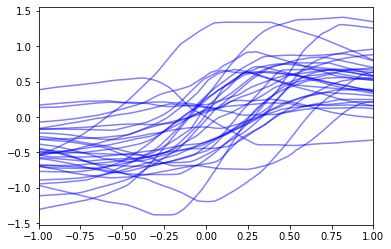

In [8]:
model.eval()
x_target = torch.Tensor(np.linspace(-1, 1, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(32):
    z_sample = torch.randn((1, z_dim))
    mu, _ = model.model.decoder(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-1, 1)

#### Visualise posterior samples

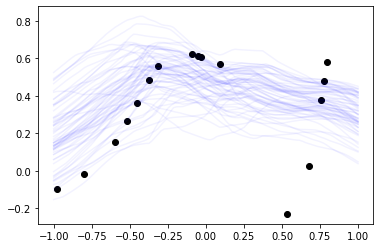

In [9]:
from train import process_data_to_points
# Extract a batch from data_loader
# Use batch to create random set of context points
rng = np.random.default_rng()
x, y, lengthscale, sigma, period = dm.train_loader.dataset.generate_gp_sample(rng)

model_x, model_y = torch.tensor(x).float().to(model.device).unsqueeze(0), torch.tensor(y).float().to(model.device).unsqueeze(0).unsqueeze(2)

x_context, y_context, _, _ = process_data_to_points(model_x, model_y, num_context)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-1, 1, 100))
# x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

model.eval()

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred, _, _ = model.model(x_context.float(), y_context.float(), x_target.float(), None)
    # Extract mean of distribution
    mu = p_y_pred[0].loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')